In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy import signal
import h5py
import pickle as pkl
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'your_path/rgc-estim-modeling/src/')
from analysis.spikes import Spikes
from analysis.stimulus import Stimulus
from analysis.sta import SpikeTriggeredAnalysis
from analysis.model import Model
from analysis.lightResponse import LightResponse
from analysis.glmnet_wrapper import GlmCVWrapper, GlmWrapper
from analysis.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load stimulus and spikes

In [4]:
stim_path = r'your_path/stim/WGNdur5_fs10000_reflect10_cutoff_100_2017_04_12_10.17.09.txt'
my_stim = Stimulus(stim_path, rcond=10**-5)
plot_path = '/your_plot_path/'

In [5]:
abs_path_sorted = r'/your_path/rgcElStim/sorted/wildtype/'
abs_path_raw = r'/your_path/rgcElStim/raw/wildtype/'
result_file_paths = [abs_path_sorted+'2017-11-03/'
                     '2017.11.03-13.10.36-standard_subfield_nofilter_mod_f_appended.cmtr',
                    abs_path_sorted+'2017-12-19/'
                    '2017.12.19-15.05.43-standard_sf_mod_lara_appended.cmtr',
                    abs_path_sorted+'2018-10-30/'
                    '2018.10.30-14.26.56-standard_hf_mod_f_appended_final.cmtr'
                    ]
light_sorted_paths = [abs_path_sorted+'2017-11-03/'
                     '2017.11.03-12.00.48-470nm_1Hz_5pc_appended.cmtr',
                    abs_path_sorted+'2017-12-19/'
                    '2017.12.19-14.46.01-470nm_5pc_1hz.cmtr',
                    abs_path_sorted+'2018-10-30/'
                    '2018.10.30-14.40.45-flick_chB_1Hz.cmtr'
                     ]
light_raw_paths = [abs_path_raw+'2017-11-03/'
                     '2017.11.03-12.00.48-470nm_1Hz_5pc_appended.cmcr',
                    abs_path_raw+'2017-12-19/'
                    '2017.12.19-14.46.01-470nm_5pc_1hz.cmcr',
                    abs_path_raw+'2018-10-30/'
                    '2018.10.30-14.40.45-flick_chB_1Hz.cmcr'
                  ]
stim_grid_dict = {'2017-11-03': [[(16, 14), (36, 32), (28, 50)], 11, 11], \
 
                     '2017-12-19': [[(42, 36), (40, 24),(6, 36)], 11, 11],\
 
                     '2018-10-30': [[(32, 8)], 27, 51]
                 }

In [6]:
(joined_spikes, 
joined_light_spikes, 
joined_matched_cells, 
joined_bias, joined_transiency) = join_spikes(result_file_paths,
                                            light_sorted_paths, 
                                            light_raw_paths,
                                            max_dist=1.5,
                                            stim_grids=stim_grid_dict)
joined_spikes.compute_benchmark()
all_cells = [cell for cell in joined_spikes.structured_ts.keys()]
robustness_thresh = 0.15
robust_cells = [cell for cell in all_cells if 
               np.average(joined_spikes.benchmark[cell])>robustness_thresh]


# Compute the whitened STA and perform clustering

The cv STA version is computed
Number of components : 3
explained variance ratio : [0.72119774 0.18091326 0.05141854]


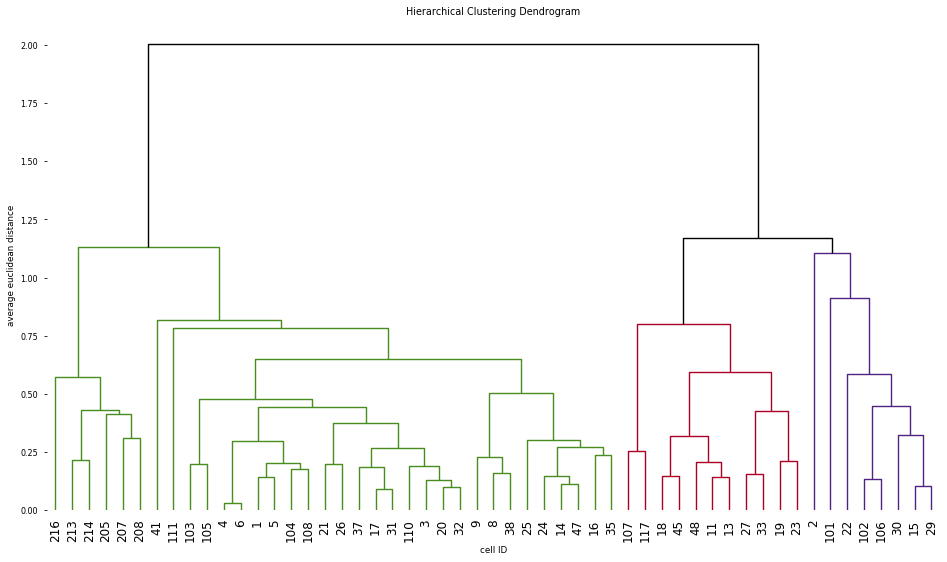

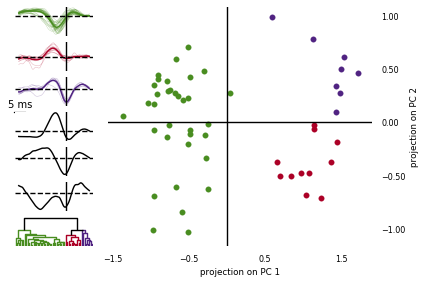

In [7]:
w_sta = SpikeTriggeredAnalysis(all_cells)
w_sta.get_spike_triggered_ensemble(joined_spikes,
                                  my_stim,
                                  mode='cv',
                                  delta_t_to_spike_back=20,
                                  delta_t_to_spike_forward=-10,
                                  whitening=True)


cluster_metric = 'euclidean'
cluster_method = 'average'

w_sta.hierarchical_cluster(robust_cells, 
                           n_clusters=3, 
                           n_components=0.95,
                           metric=cluster_metric,
                           method=cluster_method,
                           pcs=[0, 1, 2],
                          )

In [32]:
model = Model()
model.create_prediction(w_sta, all_cells)
model.fit_nonlinear_function()
model.predict(all_cells, w_sta)
model.evaluate(all_cells, joined_spikes)

cell: 1, number bins : 14
cell: 1, number bins : 15
cell: 1, number bins : 13
cell: 1, number bins : 15
cell: 1, number bins : 14
cell: 2, number bins : 12
cell: 2, number bins : 11
cell: 2, number bins : 11
cell: 2, number bins : 11
cell: 2, number bins : 11
cell: 3, number bins : 14
cell: 3, number bins : 13
cell: 3, number bins : 13
cell: 3, number bins : 13
cell: 3, number bins : 13
cell: 4, number bins : 14
cell: 4, number bins : 14
cell: 4, number bins : 13
cell: 4, number bins : 15
cell: 4, number bins : 14
cell: 5, number bins : 14
cell: 5, number bins : 13
cell: 5, number bins : 12
cell: 5, number bins : 13
cell: 5, number bins : 13
cell: 6, number bins : 14
cell: 6, number bins : 11
cell: 6, number bins : 11
cell: 6, number bins : 11
cell: 6, number bins : 11
cell: 8, number bins : 11
cell: 8, number bins : 11
cell: 8, number bins : 11
cell: 8, number bins : 11
cell: 8, number bins : 11
cell: 9, number bins : 11
cell: 9, number bins : 11
cell: 9, number bins : 11
cell: 9, num

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


# Fit GLM and perform clustering

In [ ]:
glm_cv_wrapper = GlmCVWrapper(n_jobs=-1, max_iter=1000)
glm_cv_wrapper.cv_and_fit(my_stim, 
                          joined_spikes, 
                          cells = robust_cells, 
                          filter_length_samples = 300, 
                          pre_spike_time=20, 
                          post_spike_time=-10
                         )
#with open(r'/gpfs01/euler/User/lhoefling/estim_paper/pickled items/wt/glm_cv_wrapper_robust_20200614.pkl', 'wb') as f:
#    pkl.dump(glm_cv_wrapper, f)

In [ ]:
glm_wrapper = GlmWrapper()
glm_wrapper.fit_train_test(glm_cv_wrapper,
                           my_stim,
                           joined_spikes,
                           cells = robust_cells,
                           filter_length_samples = 300, 
                           pre_spike_time=20, 
                           post_spike_time=-10
                          )
##with open(r'/gpfs01/euler/User/lhoefling/estim_paper/pickled items/wt/glm_wrapper_robust_20200614.pkl', 'wb') as f:
##    pkl.dump(glm_wrapper, f)

In [26]:
glm_wrapper.hierarchical_cluster(robust_cells, n_clusters=3, pcs=[0, 2, 3], n_components=0.95)

Number of components : 5
explained variance ratio : [0.62098097 0.17566173 0.10597591 0.03056521 0.02360911]


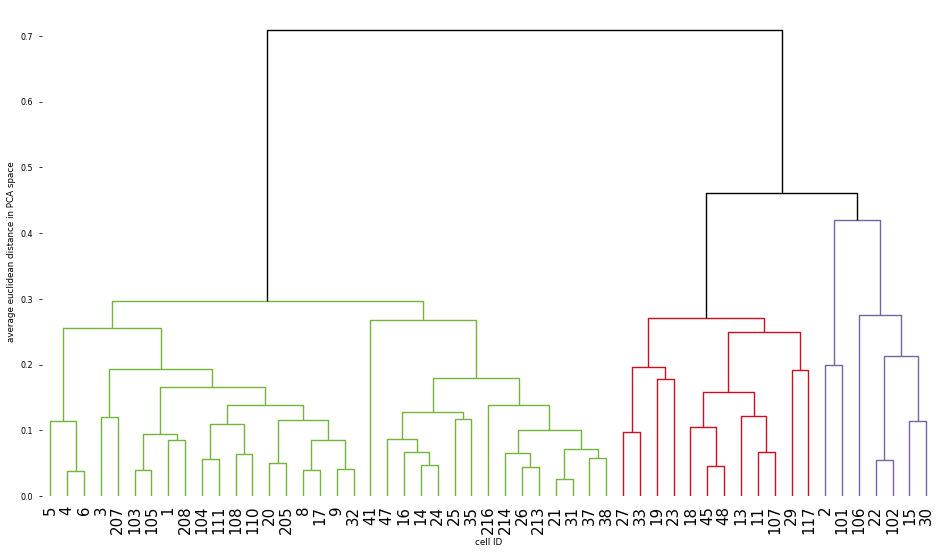

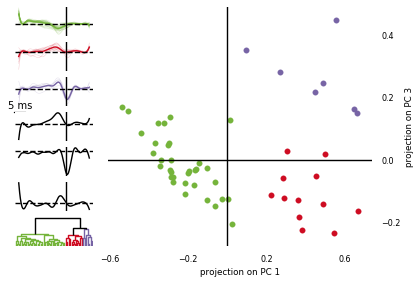

In [31]:
glm_wrapper.clustering_plot(x_start=-20, x_stop=10)